In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
# The Imports
import numpy as np
import tensorflow as tf
# Set the seed for NumPy
np.random.seed(42)
# Set the seed for TensorFlow
tf.random.set_seed(42)

In [2]:
import os, glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [3]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

In [4]:
## CLASSIFICATION_METRICS FUNCTION
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False,values_format=".2f"):
    """Modified version of classification metrics function from Intro to Machine Learning.
    Updates:
    - Reversed raw counts confusion matrix cmap  (so darker==more).
    - Added arg for normalized confusion matrix values_format
    """
    # Get the classification report
    report = classification_report(y_true, y_pred)

    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # Create a confusion matrix  of raw counts (left subplot)
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=None,
                                            cmap='gist_gray_r',# Updated cmap
                                            values_format="d",
                                            colorbar=colorbar,
                                            ax = axes[0]);
    axes[0].set_title("Raw Counts")


    # Create a confusion matrix with the data with normalize argument
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                            normalize=normalize,
                                            cmap=cmap,
                                            values_format=values_format, #New arg
                                            colorbar=colorbar,
                                            ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [5]:
def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict



In [6]:
# Checking the contents of xrays folder
data_dir = "/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week20/Data/xrays"
#Subfolders
subfolders = os.listdir(data_dir)
subfolders

['covid', 'normal', 'pneumonia']

In [7]:
# Use glob to get all files in the directory and subdirectories
img_files = glob.glob(os.path.join(data_dir, '**'), recursive=True)

# Filter out directories
img_files = [f for f in img_files if os.path.isfile(f)]

In [8]:
#how many total files there are:
len(img_files)

6949

In [9]:
# Take a look at the first 5 filepaths
img_files[0:5]

['/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week20/Data/xrays/covid/COVID-19 (62).jpg',
 '/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week20/Data/xrays/covid/COVID-19 (424).jpg',
 '/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week20/Data/xrays/covid/COVID-19 (630).jpg',
 '/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week20/Data/xrays/covid/COVID-19 (576).jpg',
 '/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week20/Data/xrays/covid/COVID-19 (473).jpg']

In [10]:

# Preview an example image (at full size)
img_loaded = load_img(img_files[0])
img_data = img_to_array(img_loaded)
img_data.shape

(1024, 1024, 3)

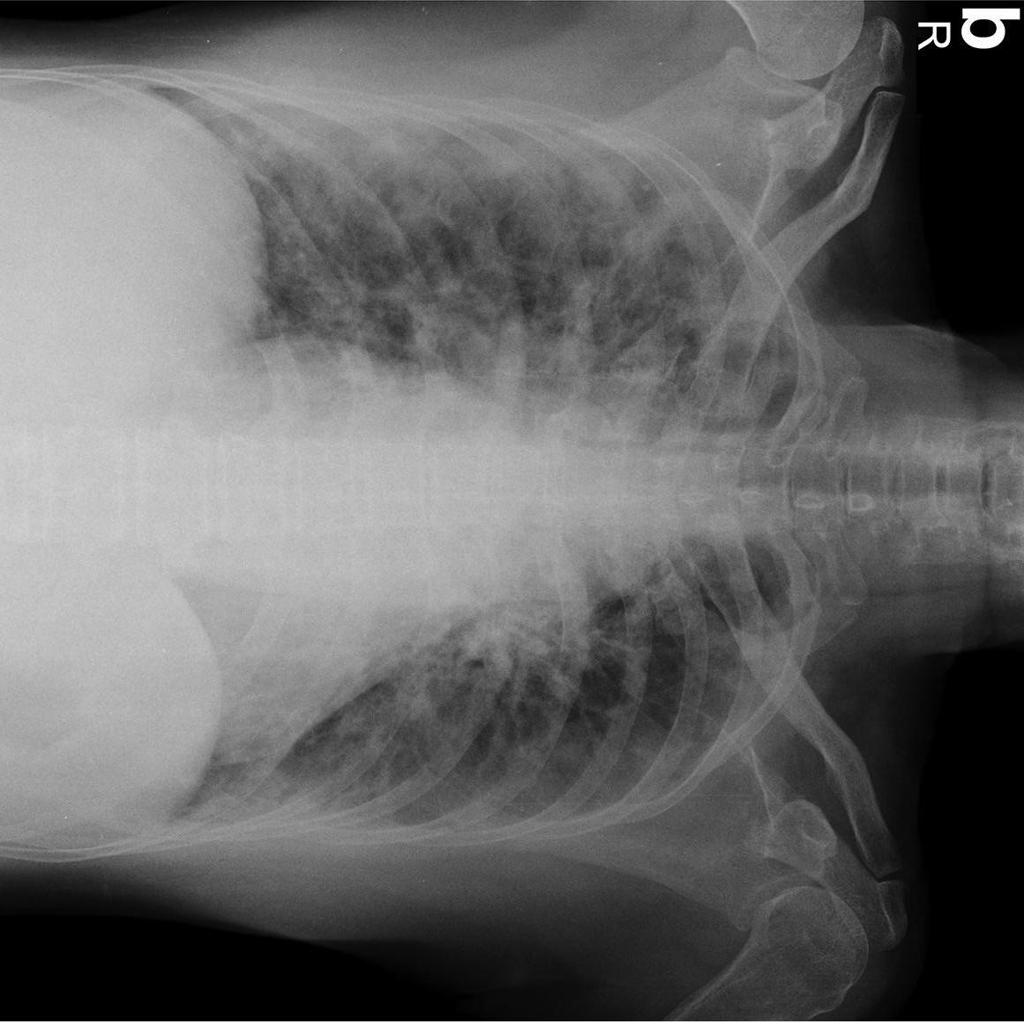

In [25]:
# Data can be converted back to image
array_to_img(img_data)

## Creating a Tensorflor Image Dataset

In [9]:
# Saving image params as vars for reuse
batch_size = 16
img_height = 96
img_width = 96

In [10]:
# make the dataset from the main folder of images
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
    shuffle=True,
    label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
ds

Found 6912 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [11]:
# Determine number of batches in dataset
ds_size = len(ds)
ds_size

432

In [12]:
# taking a sample batch to see batch shape
example_batch_imgs,example_batch_y= ds.take(1).get_single_element()
example_batch_imgs.shape

TensorShape([16, 96, 96, 3])

In [13]:
#Saving the input shape using the first image from the first batch
input_shape = example_batch_imgs[0].shape
input_shape

TensorShape([96, 96, 3])

In [14]:
#unpacking the shape using *
# Demo Unpacking shape
input_shape = [*input_shape]
input_shape

[96, 96, 3]

In [15]:
#Display the first label in the batch.
print(f'Example label: {example_batch_y[0]}')

Example label: [0. 0. 1.]


In [16]:
# The subfolders are the ones used for checking the class names
class_names = ds.class_names
class_names

['covid', 'normal', 'pneumonia']

In [17]:
# Saving # of classes
num_classes = len(class_names)

# Saving dictionary of integer:string labels
class_dict = dict(zip(range(num_classes), class_names))
class_dict

{0: 'covid', 1: 'normal', 2: 'pneumonia'}

#Train, Validation, and Test Split

In [18]:
# Set the ratio of the train, validation, test split
split_train = 0.7
split_val = 0.2
split_test = 0.1
# Calculate the number of batches for training and validation data
n_train_batches =  int(ds_size * split_train)
n_val_batches = int(ds_size * split_val)
print(f"Use {n_train_batches} batches as training data")
print(f"Use {n_val_batches} batches as validation data")
print(f"The remaining {len(ds)- (n_train_batches+n_val_batches)} batches will be used as test data.")

Use 302 batches as training data
Use 86 batches as validation data
The remaining 44 batches will be used as test data.


In [19]:
# Use .take to slice out the number of batches
train_ds = ds.take(n_train_batches)
# Confirm the length of the training set
len(train_ds)

302

In [20]:
# Skipover the training batches
val_ds = ds.skip(n_train_batches)
# Take the correct number of validation batches
val_ds = val_ds.take(n_val_batches)
# Confirm the length of the validation set
len(val_ds)

86

In [21]:
# Skip over all of the training + validation batches
test_ds = ds.skip(n_train_batches + n_val_batches)
# Confirm the length of the testing data
len(test_ds)

44

### Optimize the Dataset Performance

In [22]:
# Use autotune to automatically determine best buffer sizes
AUTOTUNE = tf.data.AUTOTUNE

# Make buffer size the same as the number of batches in train_ds
buffer_size = len(train_ds)
buffer_size

302

In [23]:
# Optimize training data
train_ds = train_ds.cache().shuffle(buffer_size= buffer_size,
                                   seed=42).prefetch(buffer_size=AUTOTUNE)
# Optimize validation data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# Optimize teset data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Convert TensorFlow Datasets to NumPy Arrays

In [41]:
# Iterating through dataset object to separate image data from label data
for images, labels in test_ds.as_numpy_iterator():
    print(f'Image data shape is {images.shape}')
    print(f'Label data shape is {labels.shape}')


Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Label data shape is (16, 3)
Image data shape is (16, 96, 96, 3)
Labe

In [24]:
def get_true_pred_labels(model,ds):
    """Gets the labels and predicted probabilities from a Tensorflow model and Dataset object.
    Adapted from source: https://stackoverflow.com/questions/66386561/keras-classification-report-accuracy-is-different-between-model-predict-accurac
    """
    y_true = []
    y_pred_probs = []

    # Loop through the dataset as a numpy iterator
    for images, labels in ds.as_numpy_iterator():

        # Get prediction with batch_size=1
        y_probs = model.predict(images, batch_size=1, verbose=0)
        # Combine previous labels/preds with new labels/preds
        y_true.extend(labels)
        y_pred_probs.extend(y_probs)
    ## Convert the lists to arrays
    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)

    return y_true, y_pred_probs

In [25]:
#Building convert_y_to_sklearn_classes
def convert_y_to_sklearn_classes(y, verbose=False):
    # If already one-dimension
    if np.ndim(y)==1:
        if verbose:
            print("- y is 1D, using it as-is.")
        return y

    # If 2 dimensions with more than 1 column:
    elif y.shape[1]>1:
        if verbose:
            print("- y is 2D with >1 column. Using argmax for metrics.")
        return np.argmax(y, axis=1)

    else:
        if verbose:
            print("y is 2D with 1 column. Using round for metrics.")
        return np.round(y).flatten().astype(int)



## Model 1: Baseline CNN Model

- The model will include: Rescaling Layer, Convolutional Layer #1, Pooling Layer #1, Convolutional Layer #2, Pooling Layer #2, Flattening Layer & an Output layer.
- The label_mode of our dataset is "categorial," so we will compile the model with 'categorical_cossentropy" for our loss function.
- I will include accuracy as an additional metric.

In [44]:
# Write the building and compiling steps within a function
def build_model():
    # Instantatie model
    model = models.Sequential()
    # Scaling layer
    scaling_layer = layers.Rescaling(1./255, input_shape=input_shape)
    model.add(scaling_layer)

    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling
    # Convolutional layer
    model.add(
        layers.Conv2D(
            filters=8,  # How many filters you want to use
            kernel_size=3,  # size of each filter
            input_shape=input_shape,
            padding='same'
        ))
    # Pooling layer
    model.add(layers.MaxPooling2D(pool_size=2))  # Size of pooling

    # Flattening layer
    model.add(layers.Flatten())
    # Output layer
    model.add(
        layers.Dense(3, activation="softmax")  # How many output possibilities we have
    )  # What activation function are you using?

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model



In [45]:
# Build the model
model1 = build_model()
# Get model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 8)         584       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4608)              0

### Fitting the baseline model

In [46]:
from tensorflow.keras.callbacks import EarlyStopping

def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]


In [47]:
import datetime as dt
# timing
start = dt.datetime.now()

# fit the neural network
epochs=20
history1 = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, callbacks = get_callbacks()
)

end = dt.datetime.now()
dur = end-start
print(f"Training time: {dur}")

Epoch 1/20
302/302 [==============================] - 188s 392ms/step - loss: 0.5726 - accuracy: 0.7686 - val_loss: 0.4675 - val_accuracy: 0.8263
Epoch 2/20
302/302 [==============================] - 27s 89ms/step - loss: 0.3891 - accuracy: 0.8659 - val_loss: 0.4485 - val_accuracy: 0.8307
Epoch 3/20
302/302 [==============================] - 24s 80ms/step - loss: 0.3403 - accuracy: 0.8814 - val_loss: 0.3846 - val_accuracy: 0.8699
Epoch 4/20
302/302 [==============================] - 26s 85ms/step - loss: 0.2929 - accuracy: 0.9017 - val_loss: 0.3976 - val_accuracy: 0.8656
Epoch 5/20
302/302 [==============================] - 24s 78ms/step - loss: 0.2723 - accuracy: 0.9077 - val_loss: 0.4011 - val_accuracy: 0.8539
Epoch 6/20
302/302 [==============================] - 24s 78ms/step - loss: 0.2444 - accuracy: 0.9216 - val_loss: 0.3535 - val_accuracy: 0.8844
Epoch 7/20
302/302 [==============================] - 26s 87ms/step - loss: 0.2265 - accuracy: 0.9274 - val_loss: 0.3518 - val_accurac

In [48]:
pip install visualkeras

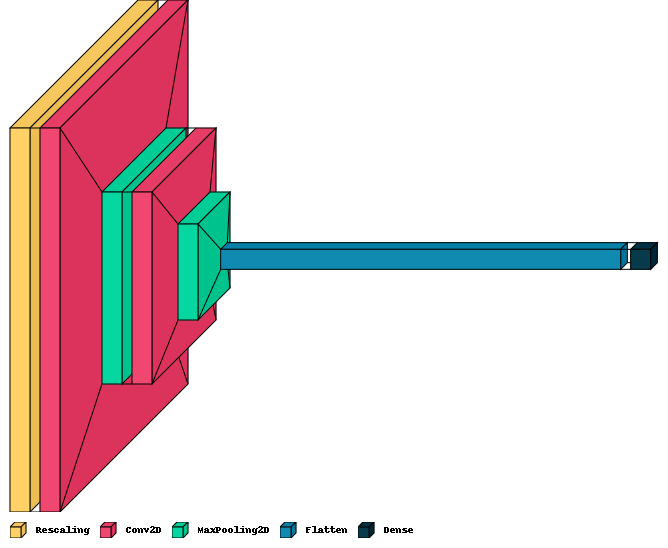

In [49]:
#display the baseline model
import visualkeras as vk

display(vk.layered_view(model1, legend=True))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.87      0.90       221
           1       0.84      0.97      0.90       257
           2       0.95      0.83      0.89       226

    accuracy                           0.90       704
   macro avg       0.91      0.89      0.90       704
weighted avg       0.90      0.90      0.90       704



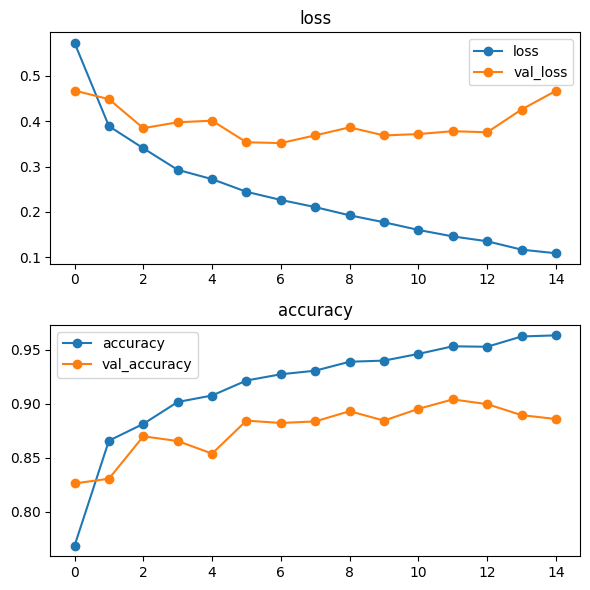

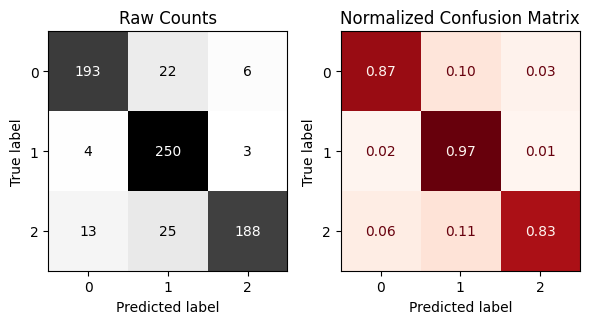


- Evaluating Test Data:
44/44 [==============================] - 4s 83ms/step - loss: 0.4550 - accuracy: 0.8963
{'loss': 0.45497673749923706, 'accuracy': 0.8963068127632141}


In [50]:
# Baseline model evaluation
evaluate_classification_network(model1, X_test=test_ds, history=history1);

## Model 2: A Complex CNN model
- Consider adding hidden Dense layers.
- Consider using KerasTuner
- Consider adding more convolutional/pooling layers.

    - Try using 2 x Conv2D layers back-to-back before the pooling layer.
    - Try changing the number of filters in each layer (the same # of filters, or increasing # of filters, etc.)

- Consider applying Data Augmentation.

In [51]:
pip install keras_tuner

In [27]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout

def build_tune_model_deep(hp):
    model = models.Sequential()
    # Scaling layer
    model.add(layers.Rescaling(1.0 / 255, input_shape=input_shape))
    # Setting hp params and saving as var so they can be used at >1 layer
    n_filters = hp.Int('filters_1',min_value=16, max_value=32, step=16)
    pool_strides = hp.Choice('pool_strides',[1,2])

    # First Convolutional layer with larger kernel size options
    model.add(layers.Conv2D(n_filters,
                            # Test using larger kernel size (in first Conv layer ONLY)
                            kernel_size= hp.Choice('kernel_size_1',[3,5]),
                            padding='same')
             )
    model.add(layers.MaxPooling2D(2, strides=pool_strides))

    # adding more convolutional layers
    for i in range(hp.Int('n_conv_layers',min_value=1, max_value=2)):
        # Double the number of filters vs. previous layer
        n_filters = n_filters * 2
        model.add(layers.Conv2D(n_filters, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D(2, strides=pool_strides))

        # Add pooling layer
        model.add(layers.MaxPooling2D(2, strides=pool_strides))

    # Final layers
    model.add(layers.Flatten())
    # Hidden layer
    model.add(layers.Dense(n_filters, activation="relu"))
    # Test various dropout strengths
    model.add(layers.Dropout(hp.Float('dropout_rate_dense',min_value=0.1, max_value=0.3,
                                     step=.1)))
    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=[
            "accuracy"],
    )
    return model

In [28]:
# Define the tuner
tuner_hb = kt.Hyperband(build_tune_model_deep, objective='val_accuracy',
                        max_epochs=5, overwrite=True, seed=321, factor=2)
# Preivew search summary
tuner_hb.search_space_summary()


Search space summary
Default search space size: 5
filters_1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 16, 'sampling': 'linear'}
pool_strides (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2], 'ordered': True}
kernel_size_1 (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
n_conv_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 2, 'step': 1, 'sampling': 'linear'}
dropout_rate_dense (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [30]:
# Use early stopping to stop training early if no improvement:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [31]:
# Run the tuner search on a smaller subset of `train_ds` and `val_ds` data

train_subset = train_ds.take(50)  # Using only the first 100 batches
val_subset = val_ds.take(10)  # Using only the first 20 batches

#Start the hyperparameter search
tuner_hb.search(train_subset, validation_data=val_subset, epochs=15, callbacks=[stop_early])

# Obtain summary of results
tuner_hb.results_summary()

Trial 21 Complete [00h 08m 12s]
val_accuracy: 0.862500011920929

Best val_accuracy So Far: 0.893750011920929
Total elapsed time: 02h 33m 51s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0015 summary
Hyperparameters:
filters_1: 16
pool_strides: 1
kernel_size_1: 5
n_conv_layers: 2
dropout_rate_dense: 0.1
tuner/epochs: 5
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0012
Score: 0.893750011920929

Trial 0009 summary
Hyperparameters:
filters_1: 32
pool_strides: 2
kernel_size_1: 3
n_conv_layers: 1
dropout_rate_dense: 0.1
tuner/epochs: 5
tuner/initial_epoch: 3
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0006
Score: 0.887499988079071

Trial 0016 summary
Hyperparameters:
filters_1: 16
pool_strides: 1
kernel_size_1: 5
n_conv_layers: 2
dropout_rate_dense: 0.2
tuner/epochs: 5
tuner/initial_epoch: 3
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0013
Score: 0.8812500238418579

Trial 0018 sum

In [32]:
#obtain the best-performing values for our hyperparameters and define our best_model
# Print the results for best paramters
print(f"Best Params: \n {tuner_hb.get_best_hyperparameters()[0].values}" )
# Define the best model
best_model = tuner_hb.get_best_models()[0]

Best Params: 
 {'filters_1': 16, 'pool_strides': 1, 'kernel_size_1': 5, 'n_conv_layers': 2, 'dropout_rate_dense': 0.1, 'tuner/epochs': 5, 'tuner/initial_epoch': 3, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0012'}


In [33]:
model2 = best_model

In [34]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

In [ ]:
import datetime as dt
# timing
start = dt.datetime.now()

# fit the neural network
epochs=20
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, callbacks =get_callbacks(patience=10)
)

end = dt.datetime.now()
dur = end-start
print(f"Training time: {dur}")


Epoch 1/20
302/302 [==============================] - 805s 3s/step - loss: 0.3743 - accuracy: 0.8686 - val_loss: 0.4002 - val_accuracy: 0.8721
Epoch 2/20
302/302 [==============================] - 694s 2s/step - loss: 0.3059 - accuracy: 0.8971 - val_loss: 0.3444 - val_accuracy: 0.8823
Epoch 3/20
302/302 [==============================] - 688s 2s/step - loss: 0.2410 - accuracy: 0.9230 - val_loss: 0.3305 - val_accuracy: 0.8975
Epoch 4/20
302/302 [==============================] - 687s 2s/step - loss: 0.2270 - accuracy: 0.9243 - val_loss: 0.4628 - val_accuracy: 0.8612
Epoch 5/20
302/302 [==============================] - 691s 2s/step - loss: 0.2601 - accuracy: 0.9125 - val_loss: 0.3056 - val_accuracy: 0.9142
Epoch 6/20
302/302 [==============================] - 693s 2s/step - loss: 0.2009 - accuracy: 0.9361 - val_loss: 0.4594 - val_accuracy: 0.8888
Epoch 7/20
302/302 [==============================] - 693s 2s/step - loss: 0.1608 - accuracy: 0.9435 - val_loss: 0.4440 - val_accuracy: 0.8786

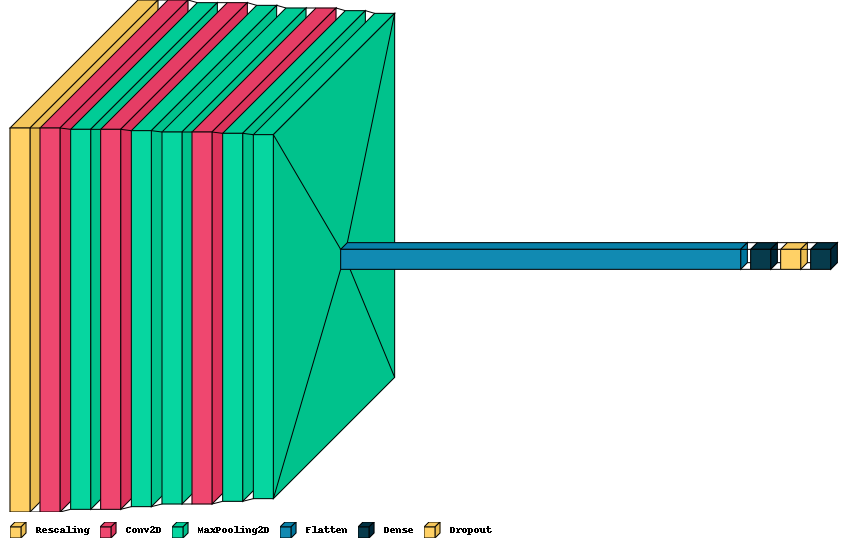

In [37]:
#display the complex model
import visualkeras as vk

display(vk.layered_view(model2, legend=True))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1586
           1       0.92      1.00      0.96      1611
           2       1.00      0.92      0.96      1635

    accuracy                           0.97      4832
   macro avg       0.97      0.97      0.97      4832
weighted avg       0.97      0.97      0.97      4832



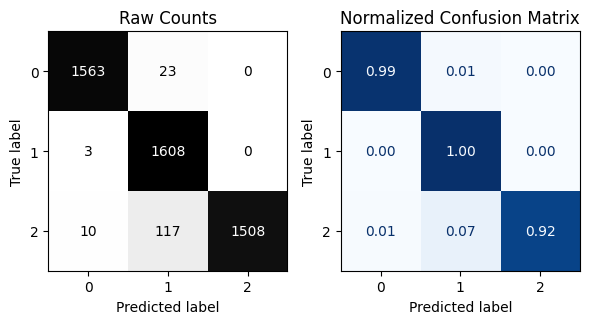


- Evaluating Training Data:
302/302 [==============================] - 104s 346ms/step - loss: 0.0838 - accuracy: 0.9683
{'loss': 0.0838349238038063, 'accuracy': 0.9683361053466797}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       218
           1       0.88      0.97      0.92       254
           2       0.99      0.86      0.92       232

    accuracy                           0.93       704
   macro avg       0.93      0.92      0.93       704
weighted avg       0.93      0.93      0.93       704



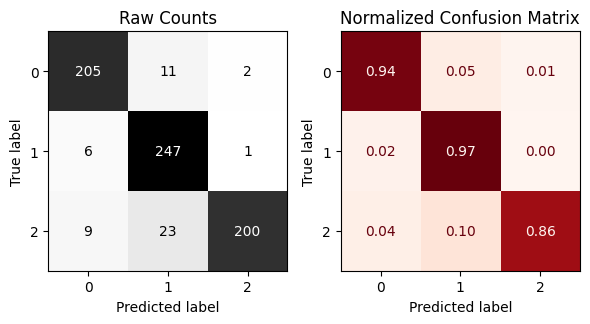


- Evaluating Test Data:
44/44 [==============================] - 15s 348ms/step - loss: 0.3784 - accuracy: 0.9261
{'loss': 0.37839382886886597, 'accuracy': 0.9261363744735718}


In [38]:
# Evalute the best model with the custom evaluation function
evaluate_classification_network(model2, X_train=train_ds, X_test=test_ds);

### Model 3: Adding Augmentation As a Layer in the Model

In [39]:
def build_aug_model():
    model = models.Sequential()
    model.add(layers.Rescaling(1.0 / 255, input_shape = input_shape))
    # Creating the data augmentation "model"
    data_augmentation = models.Sequential(
        [
            # Randomly flip image orientation
            layers.RandomFlip("horizontal_and_vertical", input_shape=input_shape),
            # Randomly rotate the image (+ values means rotating counter clock-wise)
            layers.RandomRotation(0.15),
            layers.RandomZoom(
                height_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (height)
                width_factor=(-0.2, 0.2),  # Zoom in or out up to 20% (width)
            )],  name = 'augmentation')

    model.add(data_augmentation)

    # Saving params to use in multiple layers
    n_filters = 32
    pool_strides = 2

    model.add(layers.Conv2D(n_filters,
                            kernel_size= 3,
                            padding='same')
             )
    model.add(layers.MaxPooling2D(2, strides=pool_strides))
    for i in range(3):
        n_filters = n_filters * 2
        model.add(layers.Conv2D(n_filters, kernel_size=3, padding='same'))
        model.add(layers.MaxPooling2D(2, strides=pool_strides))

    # Final layers
    model.add(layers.Flatten())
    model.add(layers.Dense(n_filters, activation="relu"))
    # Test various dropout strengths
    model.add(layers.Dropout(.1))
    model.add(layers.Dense(len(class_names), activation="softmax"))
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss='categorical_crossentropy',
        metrics=[
            "accuracy"],
    )
    # model.summary()
    return model


In [43]:
#Build,summarize, display augmented model
model3 = build_aug_model()
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 augmentation (Sequential)   (None, 96, 96, 3)         0         
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 48, 48, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 24, 24, 64)        0         
 ng2D)                                                

In [41]:
def get_callbacks(patience=3,monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience,
                                                  monitor=monitor)
    return [early_stop]

In [42]:
#Fitting the augmented model
history3 = model3.fit(
    train_ds, validation_data=val_ds, epochs=25, callbacks=get_callbacks(patience=10)
)

Epoch 1/25
302/302 [==============================] - 174s 573ms/step - loss: 0.8547 - accuracy: 0.5946 - val_loss: 0.6735 - val_accuracy: 0.7093
Epoch 2/25
302/302 [==============================] - 151s 501ms/step - loss: 0.6936 - accuracy: 0.7047 - val_loss: 0.6190 - val_accuracy: 0.7689
Epoch 3/25
302/302 [==============================] - 154s 512ms/step - loss: 0.6249 - accuracy: 0.7448 - val_loss: 0.5672 - val_accuracy: 0.7776
Epoch 4/25
302/302 [==============================] - 149s 494ms/step - loss: 0.5669 - accuracy: 0.7649 - val_loss: 0.5033 - val_accuracy: 0.8031
Epoch 5/25
302/302 [==============================] - 152s 505ms/step - loss: 0.5411 - accuracy: 0.7835 - val_loss: 0.6116 - val_accuracy: 0.7333
Epoch 6/25
302/302 [==============================] - 149s 493ms/step - loss: 0.5150 - accuracy: 0.7982 - val_loss: 0.5017 - val_accuracy: 0.7965
Epoch 7/25
302/302 [==============================] - 153s 506ms/step - loss: 0.4934 - accuracy: 0.8117 - val_loss: 0.4613 -

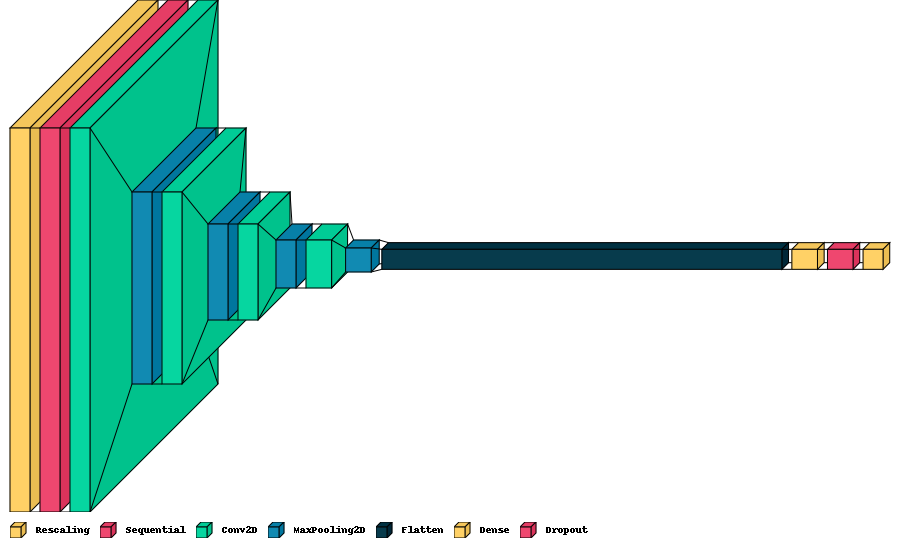

In [44]:
#Displaying the augmented model
vk.layered_view(model3, legend=True)


- Evaluating Network...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.27      0.63      0.38       218
           1       0.43      0.33      0.38       254
           2       0.00      0.00      0.00       232

    accuracy                           0.32       704
   macro avg       0.23      0.32      0.25       704
weighted avg       0.24      0.32      0.25       704



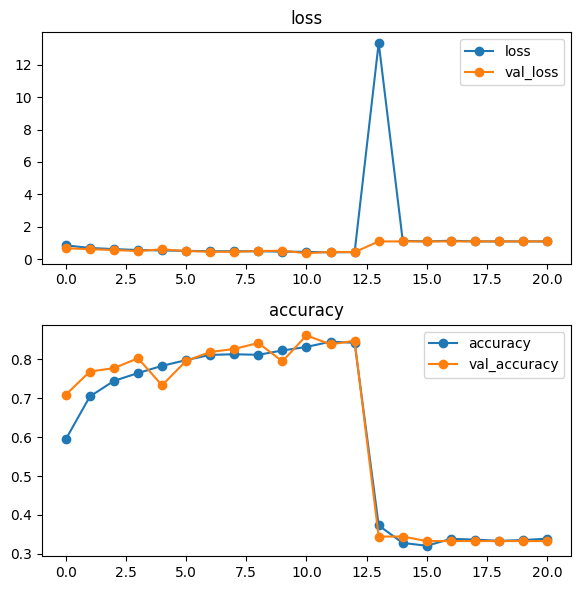

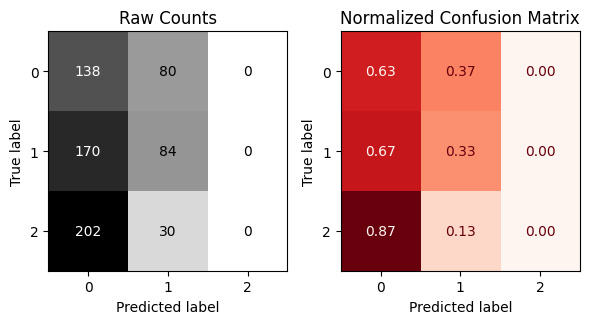

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



- Evaluating Test Data:
44/44 [==============================] - 7s 157ms/step - loss: 1.0855 - accuracy: 0.3153
{'loss': 1.0855168104171753, 'accuracy': 0.31534090638160706}


In [45]:
# Evaluating the augmented model
evaluate_classification_network(model3, X_test=test_ds, history=history3);

## Model 4: Transfer Learning

In [26]:
# Downloading just the convolutional base for feature extraction
vgg16_base = tf.keras.applications.VGG16(
    include_top=False, weights="imagenet", input_shape=input_shape
)
# Prevent layers from base_model from changing
vgg16_base.trainable = False

# Create the preprocessing lamdba layer
# Create a lambda layer for the preprocess input function for the model
lambda_layer_vgg16 = tf.keras.layers.Lambda(
    tf.keras.applications.vgg16.preprocess_input, name="preprocess_input"
)


def build_vgg16_model():
    model = models.Sequential(name="VGG16")
    # Use input layer (lambda layer will handle rescaling).
    model.add(tf.keras.layers.Input(shape=input_shape))

    ## Adding preprocessing lamabda layer
    model.add(lambda_layer_vgg16)

    # Add pretrained base
    model.add(vgg16_base)

    # Flattening layer
    model.add(layers.Flatten())

    ## Adding a Hidden Dense Layer
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))

    # Output layer
    model.add(layers.Dense(len(class_names), activation="softmax"))

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    model.summary()
    return model


58889256/58889256 [==============================] - 0s 0us/step


In [27]:
def get_callbacks(monitor='val_accuracy', patience=3, restore_best_weights=False):
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=patience,
                                                      restore_best_weights=restore_best_weights)
    return [early_stopping]

In [28]:
model4 = build_vgg16_model()
model4.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocess_input (Lambda)   (None, 96, 96, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15895363 (60.64 MB)
Trainable params: 1180675 (

In [29]:
#Fitting
history4 = model4.fit(train_ds, validation_data=val_ds,epochs=20,
                    callbacks=get_callbacks()
                         )


Epoch 1/20
302/302 [==============================] - 1327s 3s/step - loss: 2.3399 - accuracy: 0.8419 - val_loss: 0.2798 - val_accuracy: 0.9106
Epoch 2/20
302/302 [==============================] - 711s 2s/step - loss: 0.3415 - accuracy: 0.9029 - val_loss: 0.2338 - val_accuracy: 0.9244
Epoch 3/20
302/302 [==============================] - 711s 2s/step - loss: 0.2918 - accuracy: 0.9143 - val_loss: 0.2163 - val_accuracy: 0.9346
Epoch 4/20
302/302 [==============================] - 708s 2s/step - loss: 0.2486 - accuracy: 0.9218 - val_loss: 0.2057 - val_accuracy: 0.9353
Epoch 5/20
302/302 [==============================] - 736s 2s/step - loss: 0.2221 - accuracy: 0.9267 - val_loss: 0.2268 - val_accuracy: 0.9302
Epoch 6/20
302/302 [==============================] - 709s 2s/step - loss: 0.2108 - accuracy: 0.9338 - val_loss: 0.2059 - val_accuracy: 0.9404
Epoch 7/20
302/302 [==============================] - 704s 2s/step - loss: 0.1935 - accuracy: 0.9381 - val_loss: 0.2190 - val_accuracy: 0.933

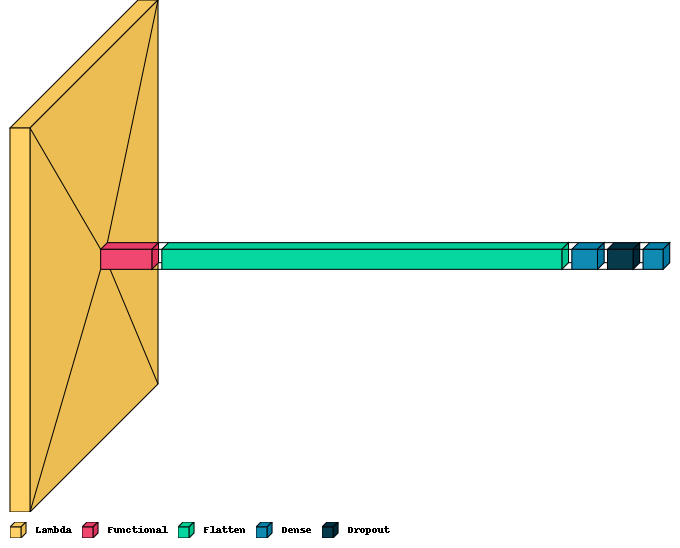

In [33]:
#Displaying the transfer learning model
import visualkeras as vk

vk.layered_view(model4, legend=True)


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.94      0.94       217
           1       0.87      0.96      0.91       256
           2       0.99      0.87      0.92       231

    accuracy                           0.92       704
   macro avg       0.93      0.92      0.92       704
weighted avg       0.93      0.92      0.92       704



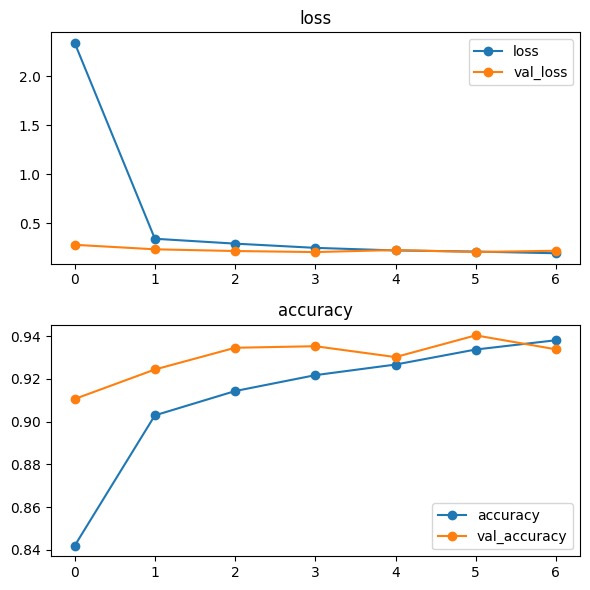

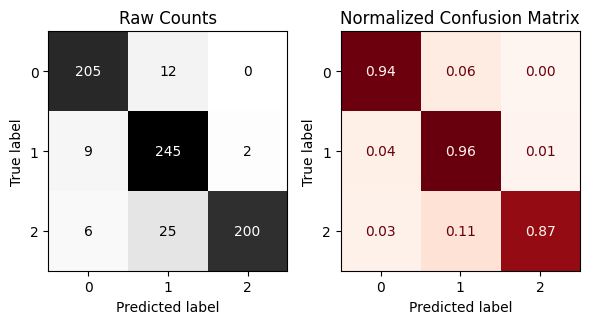


- Evaluating Test Data:
44/44 [==============================] - 83s 2s/step - loss: 0.2432 - accuracy: 0.9233
{'loss': 0.2431907206773758, 'accuracy': 0.9232954382896423}


In [34]:
evaluate_classification_network(model4,X_test=test_ds,history=history4);

# Choice of Best Model


- Model 1(Baseline CNN model) has an accuracy of 89.6%.
- Model 2 (Complex CNN model with hidden dense layers, use of the keras tuner to tune model hyperparameters, addition of more convolutional and pooling layers and increasing the number of filters)has an accuracy of 92.6%
- Model 3 (Augmented model) has a an accuracy of 31.5%.
- Model 4 (Transfer learning model) has an accuracy of 92.3%.

- Therefore my best model choice to be out into production is Model2 (the Complex CNN model)because of its high accuracy when compared to all the othert models.

In [41]:
#best model
best_model = build_best_model(input_shape, class_names)

# Save the model as a .keras file
best_model.save('/content/drive/MyDrive/CodingDojo/05-IntermediateML/Week20/best_model.keras')